In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%matplotlib inline

In [3]:
%autoreload

import matplotlib
from matplotlib import cm
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

import numpy as np
#import scipy

import darkhistory.physics as phys
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectools import discretize
import scipy.special

# import main as main

from tqdm import tqdm_notebook as tqdm

import pickle
import config
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
import string
from datetime import datetime

# Bound-bound transitions

In [4]:
#~~~ BOUND_BOUND FUNCTIONS~~~

ZEROTEMP  = 1e-10   #/* (in eV) Treat temperatures below that threshold as being exactly zero */

#*************************************************# 
#A_{nl} coefficient defined in Hey (2006), Eq. (9)# 
#*************************************************#

def Hey_A(n, l):
    return np.sqrt(n**2-l**2)/(n*l)

#/*****************************************************************# 
#Absolute value of R_{n', n'- 1}^{n n'} as in Hey (2006), Eq. (B.4) 
#Assumes n > np.
#******************************************************************#

lgamma = scipy.special.loggamma
def Hey_R_initial(n, n_p):
#     return (-1)**(n-n_p-1) * 2**(2*n_p+2) * np.sqrt(
#         fact(n+n_p)/fact(n-n_p-1)/fact(2*n_p-1)) * (
#         n_p/n)**(n_p+2) * (1-n_p/n)**(n-n_p-2)/(1+n_p/n)**(n+n_p+2)
    return np.exp(
        (2.0*n_p + 2.0) * np.log(2.0) + 
        0.5 * (lgamma(n+n_p+1) - lgamma(n-n_p) - lgamma(2.0*n_p)) 
        + (n_p + 2.0) * np.log(n_p/n) 
        + (n-n_p - 2.0) * np.log(1.0 - n_p/n) - (n + n_p + 2.0) * np.log(1.0 + n_p/n)
    )

#/*********************************************************************
#Populates a matrix with the radial matrix elements.
#Inputs: two [nmax+1][nmax+1][nmax] matrices Rup, Rdn, nmax.
#Rup is populated s.t. R_up[n][n'][l] = R([n,l],[n',l+1])
#Rdn is populated s.t. R_dn[n][n'][l] = R([n,l],[n',l-1])
#Assumption: n > n'
#**********************************************************************/

def populate_radial(nmax):
    R_up = np.zeros((nmax+1,nmax,nmax))
    R_dn = np.zeros((nmax+1,nmax,nmax))
        
    for n in np.arange(2,nmax+1,1):
        for n_p in np.arange(1,n):
            #/* Initial conditions: Hey (2006) Eq. (B.4). */
            R_dn[n][n_p][n_p] = Hey_R_initial(n, n_p)
            R_up[n][n_p][n_p-1] = R_up[n][n_p][n_p] = 0
            for l in np.arange(n_p-1,0,-1):
                #/* Hey (52-53) */
                R_dn[n][n_p][l] = ((2*l+1) * Hey_A(n, l+1) * R_dn[n][n_p][l+1] 
                    + Hey_A(n_p, l+1) * R_up[n][n_p][l]) / (2.0 * l * Hey_A(n_p, l))
         
                R_up[n][n_p][l-1] = ((2*l+1) * Hey_A(n_p, l + 1) * R_up[n][n_p][l] 
                    + Hey_A(n, l+1) * R_dn[n][n_p][l+1]) / (2.0 * l * Hey_A(n, l))
    
    return {'up': R_up, 'dn': R_dn}

# /*************************************************************************************************************** 
# Populates two matrices with the bound-bound rates for emission and absorption, 
#  in a black-body radiation field.
# Inputs : two [nmax+1][nmax+1][nmax] matrices BB_up and BB_dn, nmax, Tr (IN EV !), 
#  and the two precomputed matrices of radial matrix elements R_up and R_dn.
# BB_up[n][n'][l] = A([n,l]-> [n',l+1]) * (1 + f(E_{nn'}))                if n > n'
#                 = (2l+3)/(2l+1) exp(-E_{nn'}/Tr) * BB_dn[n'][n][l+1]    if n < n'
# BB_dn[n][n'][l] = A([n,l]-> [n',l-1]) * (1 + f(E_{nn'}))                if n > n'      
#                 = (2l-1)/(2l+1) exp(-E_{nn'}/Tr) * BB_up[n'][n][l-1]    if n < n'             
#  *****************************************************************************************************************/

hplanck = phys.hbar*2*np.pi
def populate_bound_bound(nmax, Tr, R): 
    BB = {key: np.zeros((nmax+1,nmax+1,nmax)) for key in ['up', 'dn']}
    for n in np.arange(2,nmax+1,1):
        n2 = n**2
        for n_p in np.arange(1,n,1):
            n_p2 = n_p**2
            Ennp = (1/n_p2 - 1/n2) * phys.rydberg; 
            if (Tr < ZEROTEMP):    #/* if Tr = 0*/
                fEnnp = 0.0;
            else:
                fEnnp = np.exp(-Ennp/Tr)/(1-np.exp(-Ennp/Tr))
                #fEnnp = 1/(np.exp(Ennp/Tr)-1) 

            common_factor = 2*np.pi/3 * phys.rydberg / hplanck * (
                phys.alpha * (1/n_p2 - 1/n2))**3
            
            for l in np.arange(0,n_p+1,1): #/* Spont + stim emission */
                A_up = common_factor * (l+1) / (2*l+1) * R['up'][n][n_p][l]**2
                A_dn = common_factor *   l   / (2*l+1) * R['dn'][n][n_p][l]**2
                BB['up'][n][n_p][l] = A_up * (1+fEnnp)
                BB['dn'][n][n_p][l] = A_dn * (1+fEnnp)
                         
            BB['up'][n][n_p][n_p] = BB['up'][n][n_p][n_p-1] = 0.0   #/* No l' >= n' */
            BB['dn'][n][n_p][0]   = 0.0                          #/* No l' < 0   */
            for l in np.arange(0,n_p,1): #/* Absorption obtained by detailed balance */       
                if (Tr < ZEROTEMP):  #/* if Tr = 0 */
                    BB['up'][n_p][n][l] = BB['dn'][n_p][n][l+1] = 0.0;
                else:
                    BB['up'][n_p][n][l]   = (2*l+3)/(2*l+1) * np.exp(-Ennp/Tr) * BB['dn'][n][n_p][l+1]
                    BB['dn'][n_p][n][l+1] = (2*l+1)/(2*l+3) * np.exp(-Ennp/Tr) * BB['up'][n][n_p][l]
    
    return BB

# /********************** HL FUNCTION *******************************************************************************
# Populates two matrices with the bound-bound rates for emission and absorption, in an arbitrary radiation field.
# Note that Tr parametrizes the redshift: we assume that the spectrum is almost a blackbody with temperature Tr.
# Inputs : two [nmax+1][nmax+1][nmax] matrices BB_up and BB_dn, nmax, a photon_dist structure, 
#  *****************************************************************************************************************/

# void populate_bound_bound_nonBB(
#     double ***BB_up, double ***BB_dn, unsigned nmax, double Tr, photon_dist *dist, double ***R_up, double ***R_dn
# ){
#     /* If it is a blackbody, call the old function. */
#     if (dist->blackbody){
#         populate_bound_bound(BB_up, BB_dn, nmax, Tr, R_up, R_dn);
#     }
#     else{
#         unsigned l, n, np; 
#         double n2, np2, Ennp, rs, fEnnp, common_factor, A_up, A_dn; 
#         for (n = 2; n <= nmax; n++){
#             n2 = ((double) n) * ((double) n);
#             for (np = 1; np < n; np++){
#                 np2 = ((double) np) * ((double) np); 
#                 Ennp = (1.0 / np2 - 1.0 / n2) * EI;
#                 /* Calculate redshift, obtain the photon occupancy */
#                 rs = Tr/Tr0;
#                 fEnnp = dist->f_occup(Ennp, rs);
#                 common_factor = 2.0 * np.pi/3.0 * EI / hPlanck * pow(alpha_fs *(1.0 / np2 - 1.0 / n2), 3.0);
#                 for (l = 0; l <= np; l++){
#                     /* Spont + stim emission */
#                     A_up = common_factor * (l + 1.0) / (2.0 * l + 1.0) * R_up[n][np][l] * R_up[n][np][l];
#                     A_dn = common_factor *     l     / (2.0 * l + 1.0) * R_dn[n][np][l] * R_dn[n][np][l];
#                     BB_up[n][np][l] = A_up * (1.0 + fEnnp);
#                     BB_dn[n][np][l] = A_dn * (1.0 + fEnnp);
#                 BB_up[n][np][np] = BB_up[n][np][np-1] = 0.0;   /* No l' >= n' */
#                 BB_dn[n][np][0] = 0.0;                         /* No l' < 0   */
#                 for (l = 0; l < np; l++){
#                     #/* Replaced Boltzmann weight by f/(1+f) */   
#                     BB_up[np][n][l]   = (2.0 * l + 3.0) / (2.0 * l + 1.0) * (fEnnp / (1.0 + fEnnp)) * BB_dn[n][np][l+1];
#                     BB_dn[np][n][l+1] = (2.0 * l + 1.0) / (2.0 * l + 3.0) * (fEnnp / (1.0 + fEnnp)) * BB_up[n][np][l];


# Bound-free transitions

In [5]:
#~~~ BOUND_FREE FUNCTIONS ~~~

EI       = 13.5982860719383 #/*13.60569193 / (1.0 + me_mp)*/       /* Ionization energy of hydrogen in eV, accounting for reduced mass */
alpha_fs = 7.2973525376e-3                                                     #/* Fine structure constant */
hPlanck  = 4.13566733e-15                                                      #/* Planck's constant in eV*s */
cLight   = 2.99792458e10                                                       #/* Speed of light in cm/s */
mue      = 510720.762779219              #/*me / (1.0 + me_mp)*/               #/* Reduced mass of hydrogen in eV*/ 

# /*********************************************************************************************************************
# Populates two matrices with the coefficients g(n, l; kappa, l+1) and g(n, l; kappa, l-1).
# Input: two [nmax] matrices g_up and g_dn, n, kappa.
# The matrices are populated s.t. g_up[l] = g(n, l; kappa, l+1) 
#                                 g_dn[l] = g(n, l; kappa, l-1).
# Reference: Burgess A.,1965, MmRAS..69....1B, Eqs. (28)-(34). 
# **********************************************************************************************************************/

def populate_gnlk(nmax, n, kappa):
    gnk_up = np.zeros((nmax, len(kappa)))
    gnk_dn = np.zeros((nmax, len(kappa)))
    
    k2 = kappa**2
    n2 = n**2
        
    log_product = 0.0;
    
    for s in range(1, n+1):
        log_product = log_product + np.log(1.0 + s*s*k2)
    log_init = (0.5 * (np.log(np.pi/2) - lgamma(2.0 * n)) + np.log(4.0) + n * np.log(4.0 * n) + 0.5 * log_product
             - 0.5 * np.log(1.0 - np.exp(-2.0 * np.pi / kappa)) - 2.0 * np.arctan(n * kappa) / kappa 
             - (n + 2.0) * np.log(1.0 + n2 * k2))
    gnk_up[n-1] = np.exp(log_init)
    gnk_dn[n-1] = 0.5 * np.sqrt((1.0 + n2 * k2) / (1.0 + (n - 1.0) * (n - 1.0) * k2)) / n * gnk_up[n-1]
 
    if n > 1:
        gnk_up[n-2] = 0.5 * np.sqrt((2.0 * n - 1.0) * (1.0 + n2 * k2)) * gnk_up[n-1]    
        gnk_dn[n-2] = 0.5 * (4.0 + (n - 1.0) * (1.0 + n2 * k2)) * np.sqrt(
            (2.0 * n - 1.0) / (1.0 + (n - 2.0) * (n - 2.0) * k2)) / n * gnk_dn[n-1]  
        for l in range(n-1,1,-1): 
            l2 = l**2
            gnk_up[l-2] = 0.5 * (((4.0 * (n2 - l2) + l * (2.0 * l - 1.0) * (1.0 + n2 * k2)) * gnk_up[l-1]
                              - 2.0 * n * np.sqrt((n2 - l2) * (1.0 + (l + 1.0) * (l + 1.0) * k2)) * gnk_up[l])
                                / np.sqrt((n2 - (l - 1.0) * (l - 1.0)) * (1.0 + l2 * k2)) / n)
        
        for l in range(n-2,0,-1):  
            l2 = l**2;
            gnk_dn[l-1] = 0.5 * (((4.0 * (n2 - l2) + l * (2.0 * l + 1.0) * (1.0 + n2 * k2)) * gnk_dn[l]
                              - 2.0 * n * np.sqrt((n2 - (l + 1.0) * (l + 1.0)) * (1.0 + l2 * k2)) * gnk_dn[l+1])
                              / np.sqrt((n2 - l2) * (1.0 + (l - 1.0) * (l - 1.0) * k2)) / n)
    return np.transpose(gnk_up), np.transpose(gnk_dn)

# /********************************************************************************************
# k2[n][ik] because boundaries depend on n
#  ********************************************************************************************/

def populate_k2_and_g(nmax, TM):
    k2_tab = np.zeros((nmax+1,10 * (NBINS-1) + 11))
    g = {key: np.zeros((nmax+1,Nkappa,nmax)) for key in ['up', 'dn']}
    k2max = 7e2*TM/EI        

    for n in range(1,nmax+1):
        k2min = 1e-25/n/n
        bigBins = np.logspace(np.log10(k2min), np.log10(k2max), NBINS + 1)
#         for iBig in range(NBINS):
#             temp = np.linspace(bigBins[iBig], bigBins[iBig+1], 11)
#             for i in range(11):
#                 k2_tab[n][10 * iBig + i] = temp[i]
        iBig = np.arange(NBINS)
        temp = np.linspace(bigBins[iBig], bigBins[iBig+1], 11)
        for i in range(11):
            k2_tab[n][10 * iBig + i] = temp[i]
        ik = np.arange(10 * NBINS + 1)
        g['up'][n,ik], g['dn'][n,ik] = populate_gnlk(nmax, n, np.sqrt(k2_tab[n,ik]))  
    return k2_tab, g


# /******************************************************************************************* 
# 11 point Newton-Cotes integration.
# Inputs: an 11-point array x, an 11-point array f(x).
# Output: \int f(x) dx over the interval provided.
# ********************************************************************************************/

def Newton_Cotes_11pt(x, f):
    h = (x[10] - x[0])/10.0 #/* step size */

    return (5.0 * h * (16067.0 * (f[0] + f[10]) + 106300.0 * (f[1] + f[9]) 
                      - 48525.0 * (f[2] + f[8]) + 272400.0 * (f[3] + f[7])
                      - 260550.0 * (f[4] + f[6]) + 427368.0 * f[5]) / 299376.0)

# /********************************************************************************************* 
# Populating the photoionization rates beta(n, l, Tr)
# Input: beta[nmax+1][nmax], Tr in eV, nmax
# and the precomputed tables n2k2, g_up[nmax+1][Nkappa][nmax], g_dn[nmax+1][Nkappa][nmax], 
# where Nkappa = 10 * NBINS + 1
# *********************************************************************************************/

def populate_beta(TM, Tr, nmax, k2_tab, g):
    k2 = np.zeros((11, NBINS))
    int_b = np.zeros((11, NBINS))
    common_factor =  2.0/3.0 * alpha_fs**3 * EI/hPlanck
    beta = np.zeros((nmax+1,nmax))

    for n in range(1, nmax+1):
        n2 = n**2
        for l in range(n):
            iBin = np.arange(NBINS)
            for i in range(11):
                ik = 10 * iBin + i
                k2[i] = k2_tab[n][ik]
                if (Tr < 1e-10):      #/* Flag meaning TR = 0 */
                    int_b[i] = 0.0
                else:
                    int_b[i] = ((1.0 + k2[i]*n2)**3 / (np.exp(EI / Tr * (k2[i] + 1.0 / n2)) - 1.0) * 
                                  ((l + 1.0) * g['up'][n,ik,l] * g['up'][n,ik,l] 
                                   + l * g['dn'][n,ik,l] * g['dn'][n,ik,l]))
            beta[n][l] += np.sum(Newton_Cotes_11pt(k2, int_b))
            beta[n][l] *= common_factor / n2 / (2.0 * l + 1.0)
    return beta

# /********************************************************************************************* 
# Populating the recombination coefficients alpha(n, l, Tm, Tr) 
# Input: alpha[nmax+1][nmax], Tm, Tr in eV, nmax
# and the precomputed tables n2k2, g_up[nmax+1][Nkappa][nmax], g_dn[nmax+1][Nkappa][nmax], 
# where Nkappa = 10 * NBINS + 1
# *********************************************************************************************/


# /****************************************************************************************/

def populate_alpha(Tm, Tr, nmax, k2_tab, g):
    k2 = np.zeros((11, NBINS))
    int_a = np.zeros((11, NBINS))   
    common_factor = (2.0/3.0 * alpha_fs**3 * EI/hPlanck 
                     * (hPlanck**2 * cLight**2/(2.0 * np.pi * mue * Tm))**1.5)
    alpha = np.zeros((nmax+1,nmax))
    
    for n in range(1,nmax+1):
        n2 = n**2
        for l in range(n):
            iBin = np.arange(NBINS)
            for i in range(11):
                ik = 10 * iBin + i
                k2[i] = k2_tab[n][ik]
                int_a[i] = ((1.0 + n2 *k2[i])**3 * np.exp(-k2[i] * EI / Tm) *
                             ((l + 1.0) * g['up'][n,ik,l] * g['up'][n,ik,l] 
                              + l * g['dn'][n,ik,l] * g['dn'][n,ik,l]))
                if Tr > 1e-10:
                    int_a[i] /= (1. - np.exp(-EI/Tr*(k2[i] + 1./n2)))
            alpha[n][l] += np.sum(Newton_Cotes_11pt(k2, int_a))
            alpha[n][l] *= common_factor / n2
    return alpha

# Cross-checks

In [6]:
# For calculating Sobolev optical depth
hplanck = phys.hbar*2*np.pi
#astro-ph/9912182 Eq. 40
def tau_np_1s(n, R, rs, xHI=None):
    l=1
    nu = (1 - 1/n**2) * phys.rydberg/hplanck
    lam = phys.c/nu
    if xHI == None:
        xHI = 1-phys.xHII_std(rs)
    nHI = xHI * phys.nH*rs**3
    pre = lam**3 * nHI / (8*np.pi*phys.hubble(rs))
    
    common_factor = 2*np.pi/3 * phys.rydberg / hplanck * (
        phys.alpha * (1 - 1/n**2))**3
    
    A_dn = common_factor * l/(2*l+1) * R['dn'][n][1][l]**2
    g = (2*l+1)/(2*l-1)
    return pre * A_dn * g 

# Eq. 41
def p_np_1s(n, R, rs, xHI=None):
    tau = tau_np_1s(n, R, rs, xHI=xHI)
    return (1-np.exp(-tau))/tau

In [7]:
def print_transition(init, alpha, beta, BB):
    # Tools to translate atomic orbital notation
    spectroscopic = ['s', 'p', 'd', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n']
    spec_dict = {spec: i for i,spec in enumerate(spectroscopic)}
        
    # For ionized state, we only care about recombinations
    if init == 'ion':
        # Calculate total rate to transition
        tot_rate = np.sum(alpha)  #np.sum(BB['dn'][n,:,l]+BB['up'][n,:,l])
        
        print('Recombination coefficients')
        print('total: ', str(tot_rate), 'cm^3 s^-1\n')
        #print('fractional:')
        
        for n in range(1,alpha.shape[0]):
            for l in range(n):
                print(str(n) + list(spec_dict.keys())[list(spec_dict.values()).index(l)], 
                      '  ', alpha[n][l])#/tot_rate)
        
    # Otherwise, we need to print all transitions and photoionizations
    else:
        n = int(init[0])
        l = spec_dict[init[1]]

        # Calculate total rate to transition
        tot_rate = np.sum(BB['dn'][n,:,l]+BB['up'][n,:,l])

        print(init+' transition/ionization rates\n')
        # Photoionization
        print('ionization: ', str(beta[n][l]), 's^-1')
        print('total transition: ', str(tot_rate), 's^-1\n')
        print('fraction of transitions:')

        # If in lowest angular momentum state, can only transition up
        # So just print one column
        if l==0:
            print('n', 'p')
            for n_p in np.arange(1,BB['up'].shape[0],1):
                print(n_p, '{:.2e}'.format(BB['up'][n][n_p][l]/tot_rate))
        else:
            # Angular momentum must change by one, 
            # so print a column for going up and a column for down
            print('n', spectroscopic[l-1], '        ', spectroscopic[l+1])

            # n_p enumerates the other n's to transition to
            for n_p in np.arange(1,BB['up'].shape[0],1):
                # If n = 1 or 2, there is only one angular momentum state to transition to: l = 0
                if n_p <=l:
                    print(n_p, '{:.2e}'.format(BB['dn'][n][n_p][l]/tot_rate))
                else:
                    print(n_p, '{0:.2e}   {1:.2e}'.format(BB['dn'][n][n_p][l]/tot_rate, 
                                                          BB['up'][n][n_p][l]/tot_rate))

        if (l==0) and (n==2):
            print('special case, 2s -> 1s: ', BB['dn'][2][1][0]/tot_rate)

In [8]:
### Starting parameters
rs=600
nmax=15

xHI = 1-phys.xHII_std(rs)
Tr  = phys.TCMB(rs)
TM  = phys.Tm_std(rs)
NBINS = 100
Nkappa = 10 * NBINS + 1

### POPULATE!!!!!

# Timing
starttime = datetime.now()
R = populate_radial(nmax)
BB = populate_bound_bound(nmax, Tr, R)
# I have checked that BB(2p->1s) is correct (1.5e-9 s^-1)
print((datetime.now() - starttime).total_seconds())

# Timing
starttime = datetime.now()
k2_tab, g = populate_k2_and_g(nmax, TM)
alpha = populate_alpha(TM, Tr, nmax, k2_tab, g)
beta = populate_beta(TM, Tr, nmax, k2_tab, g)
print((datetime.now() - starttime).total_seconds())

#Include sobolev optical depth
for n in np.arange(2,nmax+1,1):
#     print(n, p_np_1s(n, R, rs, xHI=xHI))
    BB['dn'][n][1][1] = p_np_1s(n, R, rs, xHI=xHI) * BB['dn'][n][1][1]
    
#Include forbidden 2s->1s transition
BB['dn'][2][1][0] = phys.width_2s1s_H

#I have checked that the Sobolev Optical Depth 
#for 2p-1s is correct for rs<=3e3 (up to 4th digit)  

0.023159
0.087608


/Users/viviesque/opt/anaconda3/envs/DarkHistoryEnvironment/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: overflow encountered in exp


In [9]:
print_transition('2p', alpha, beta, BB)

2p transition/ionization rates

ionization:  0.00027918312663893633 s^-1
total transition:  167.66050797713646 s^-1

fraction of transitions:
n s          d
1 1.32e-02
2 0.00e+00   0.00e+00
3 1.88e-02   9.65e-01
4 7.05e-05   2.82e-03
5 4.01e-06   1.47e-04
6 7.03e-07   2.46e-05
7 2.15e-07   7.35e-06
8 9.04e-08   3.04e-06
9 4.60e-08   1.53e-06
10 2.67e-08   8.81e-07
11 1.69e-08   5.55e-07
12 1.15e-08   3.74e-07
13 8.15e-09   2.65e-07
14 6.02e-09   1.96e-07
15 4.59e-09   1.49e-07


In [10]:
print_transition('ion', alpha, beta, BB)

Recombination coefficients
total:  1.3658403350864067e-12 cm^3 s^-1

1s    4.0598227593319777e-13
2s    5.966445254027431e-14
2p    1.5797866390702355e-13
3s    2.007422636176494e-14
3p    6.00944029887682e-14
3d    6.428562960251344e-14
4s    9.381928184782638e-15
4p    2.8779096196145105e-14
4d    4.031224315499636e-14
4f    2.662711050737593e-14
5s    5.2643860231882384e-15
5p    1.6228595625984082e-14
5d    2.4893385918146815e-14
5f    2.3690614341348007e-14
5g    1.1069723061528714e-14
6s    3.342492147244957e-15
6p    1.0303412045563688e-14
6d    1.6452910075123074e-14
6f    1.8134785945927975e-14
6g    1.2991029242987263e-14
6h    4.653319325910514e-15
7s    2.3179088355712596e-15
7p    7.135550314944277e-15
7d    1.1632787316212239e-14
7f    1.383454190563736e-14
7g    1.195912819507411e-14
7h    6.85629140479672e-15
7i    1.990887958958216e-15
8s    1.7122706329089285e-15
8p    5.262974376843957e-15
8d    8.682130821414955e-15
8f    1.0800415717407856e-14
8g    1.0366202963511

ValueError: 12 is not in list

In [ ]:
# Compare to tables in 1965MmRAS..69...1B
# X = n^2 k^2
n2 = np.arange(nmax+1)**2

theta_up = np.transpose(np.transpose((1.0 + np.transpose(n2*np.transpose(k2_tab)))) 
                        * np.transpose(g['up']**2))
theta_dn = np.transpose(np.transpose((1.0 + np.transpose(n2*np.transpose(k2_tab)))) 
                        * np.transpose(g['dn']**2))

In [ ]:
# Choose which n and l to compare to
test_n = 1
test_l = 0

# ~~~ Table 1 ~~~
# Interpolate so we can compare to the Xs shown in the table
theta_dn_interp = interp1d(test_n**2 * k2_tab[test_n], theta_dn[test_n,:,test_l], fill_value='extrapolate')
theta_up_interp = interp1d(test_n**2 * k2_tab[test_n], theta_up[test_n,:,test_l], fill_value='extrapolate')

Xs = [0.000,0.005,0.010,0.020,0.040,0.080,0.160,0.320,0.640,1.280,2.560,5.120,10.24,20.48,40.96]

print('X            dn            up')
for i, X in enumerate(Xs):
    print(f'{X:.3e}    {theta_dn_interp(X):.4e}    {theta_up_interp(X):.4e}')
print('\n\n')

# SUCCESS!!!


# ~~~ Table 2 ~~~
ts = [1e5, 64, 32, 16, 8, 4, 2, 1, 1/2, 1/4, 1/8, 1/16, 1/32, 1/64, 1e-10]

k2 = np.zeros(11)
int_up = np.zeros(11)   
int_dn = np.zeros(11)

phi_up = np.zeros_like(ts)
phi_dn = np.zeros_like(ts)

n2 = test_n**2
print('t            dn          up')
for ind, t in enumerate(ts):
    for iBin in range(NBINS):
        for i in range(11):
            ik = 10 * iBin + i
            k2[i] = k2_tab[test_n][ik]
            int_up[i] = (15.789) * (1.0 + n2 *k2[i])**3 * np.exp(-k2[i] * 15.789/t) * (test_l + 1.0) * g['up'][test_n][ik][test_l] * g['up'][test_n][ik][test_l]
            int_dn[i] = (15.789) * (1.0 + n2 *k2[i])**3 * np.exp(-k2[i] * 15.789/t) * test_l * g['dn'][test_n][ik][test_l] * g['dn'][test_n][ik][test_l]
        phi_up[ind] += Newton_Cotes_11pt(k2, int_up)
        phi_dn[ind] += Newton_Cotes_11pt(k2, int_dn)
    if t < 1:
        phi_up[ind] /= t
        phi_dn[ind] /= t
    print(f'{t:.3e}    {phi_dn[ind]:.3e}    {phi_up[ind]:.3e}')

# Disagrees at very large values of t? but, otherwise, success!

### Spectrum from cascading to ground/continuum state

In [11]:
from config import load_data

### DarkHistory bins for photon energies
# binning = load_data('binning')
# photeng = binning['phot']

### Precise bins
#photeng = np.logspace(np.log10(0.044), np.log10(13.7), 5000)

### Exact energy bins; recall that energy labels bin center, not edge
photeng = np.zeros((nmax+1,nmax+1))
photengs_Cont = np.zeros(nmax+1)
for n1 in range(1,nmax+1):
    photengs_Cont[n1] = phys.rydberg / n1**2
    photeng[0,n1] = phys.rydberg / n1**2
    for n2 in range(1,n1):
        photeng[n1,n2] = phys.rydberg * ((1/n2)**2 - (1/n1)**2)
        
photeng = np.sort(np.unique(photeng))
# Add a separate energy bin to temporarily represent 2s->1s
photeng = np.concatenate((photeng,[20]))

# Get indices where alpha != 0 --> correspond to ground and excited states
nonzero_n, nonzero_l = alpha.nonzero()

# Make array that has the n of each excited state
ns = np.zeros(int(nmax*(nmax+1)/2))
counter = 0
for i in range(1,nmax+1):
    ns[counter:counter + i] = i
    counter += i

In [12]:
### Build probability matrix for single transition, P_ij
P_matrix = np.zeros((len(nonzero_n)+1, len(nonzero_n)+1))

# Ground and continuum states are sink states
P_matrix[0,0] = 1
P_matrix[-1,-1] = 1

for nl in range(1, len(nonzero_n)):
    # Find indices for possible states to transition to (l must change by 1)
    # Get the rates for transitioning to those states, as well as total rate
    if nonzero_l[nl] != 0:
        dn_inds = np.where(nonzero_l == nonzero_l[nl]-1)[0]
        dn_rates = BB['dn'][nonzero_n[nl], nonzero_n[dn_inds], nonzero_l[nl]]
    else:
        # If angular momentum is 0, can only transition up
        dn_rates = 0
        
    up_inds = np.where(nonzero_l == nonzero_l[nl]+1)[0]
    up_rates = BB['up'][nonzero_n[nl], nonzero_n[up_inds], nonzero_l[nl]]
    tot_rate = np.sum(up_rates) + np.sum(dn_rates) + beta[nonzero_n[nl]][nonzero_l[nl]]
    
    # Special 2s->1s transition
    if nl == 1:
        tot_rate += BB['dn'][2][1][0]
        P_matrix[1][0] = BB['dn'][2][1][0] / tot_rate
        
    # Normalize by total rate for each state to get probabilities instead of rates
    if nonzero_l[nl] != 0:
        P_matrix[nl][dn_inds] = dn_rates / tot_rate
    P_matrix[nl][up_inds] = up_rates / tot_rate
    P_matrix[nl][-1] = beta[nonzero_n[nl]][nonzero_l[nl]] / tot_rate

In [13]:
### Calculate probability of any state going to 1s after many transitions

# Vector of probabilities for single transition
Pto1s = P_matrix[1:-1,0]
PtoCont = P_matrix[1:-1,-1]

P_sub = P_matrix[1:-1,1:-1]
P_series = np.linalg.inv(np.identity(len(Pto1s)) - P_sub)

# Geometric series with single-transition matrix
Pto1s_many = np.dot(P_series, Pto1s)
PtoCont_many = np.dot(P_series, PtoCont)

print('Probability to be in 1s after many transitions:')
print(Pto1s_many)

print('\n')
print('Probability to be in continuum after many transitions:')
print(PtoCont_many)

print('\n')
print('Check these add up to 1, since there are no other sink states:')
print(Pto1s_many + PtoCont_many)

Probability to be in 1s after many transitions:
[0.99981525 0.9994961  0.99947533 0.99980753 0.9994929  0.99837112
 0.99928654 0.99931115 0.99893991 0.99182352 0.99643103 0.99748998
 0.99521711 0.99374532 0.97852368 0.98968198 0.99290197 0.98646947
 0.98097214 0.98035916 0.96078154 0.97954369 0.98571982 0.97368203
 0.96239389 0.95811972 0.96208986 0.94117383 0.96727734 0.97674763
 0.95868019 0.94102512 0.93207279 0.93441484 0.94430598 0.92134102
 0.95397869 0.96677548 0.94292179 0.91910524 0.90526071 0.90510707
 0.91573792 0.93015518 0.90210504 0.94038726 0.95640087 0.92733491
 0.89793631 0.87941147 0.87634343 0.88678157 0.90390084 0.92037807
 0.88376509 0.9269464  0.9460463  0.9124662  0.87819286 0.85537199
 0.84920566 0.8587042  0.87764733 0.89808626 0.91441416 0.86627943
 0.9138917  0.93602479 0.8986476  0.86021295 0.83351396 0.82415639
 0.83205346 0.85188944 0.87567226 0.89652284 0.91128716 0.84927361
 0.90130656 0.92662344 0.88613914 0.8442141  0.81401439 0.80136011
 0.80697442 0.

In [14]:
### Build matrix for photon spectra from single transitions
# Since this is a photon spectrum, the length of the last axis is the number of photon energy bins
NE_single = np.zeros((len(nonzero_n)+1, len(nonzero_n)+1, len(photeng)))

# We are only putting one photon in one bin, so spectrum already correctly normalized
# Run over initial excited states
for nli in range(len(nonzero_n)):
    #Bound-free transitions
    eng = phys.rydberg / ns[nli]**2
    # Find correct energy bin
    ind = np.where(photeng <= eng)[0][-1]
    # Add 1 photon for emission, -1 for absorption
    NE_single[nli,-1,ind] = -1
    NE_single[-1,nli,ind] = 1
    
    #Bound-bound transitions
    # Run over final states
    for nlf in range(len(nonzero_n)):
        # Put 2s->1s transition in special energy bin
        if (nli == 1) and (nlf == 0):
            ind = np.where(photeng <= 20)[0][-1]
            NE_single[nli,nlf,ind] = 1
        else:
            # Energy of photon emitted/absorped
            eng = phys.rydberg * ((1/ns[nlf])**2 - (1/ns[nli])**2)
            if eng != 0.0:
                # Find correct energy bin
                ind = np.where(photeng <= abs(eng))[0][-1]
                # Add 1 photon if emission, -1 for absorption
                NE_single[nli,nlf,ind] = np.sign(eng)

### Calculate spectrum from cascading to 1s after many transitions
PNE_1s = np.dot(P_matrix[:-1,:-1], NE_single[:-1,:-1])
PNE_diag_1s = np.transpose(np.diagonal(PNE_1s))
NE_1s = np.dot(P_series, PNE_diag_1s[1:])

### Calculate spectrum from going up to continuum after many transitions
PNE_Cont = np.dot(P_matrix[1:,1:], NE_single[1:,1:])
PNE_diag_Cont = np.transpose(np.diagonal(PNE_Cont))
NE_Cont = np.dot(P_series, PNE_diag_Cont[:-1])

In [15]:
# Most photons are double counted between transitions to 1s and to continuum.
# What the continuum spectrum does not have are the photons corresponding to 
# the final transition to 1s, which all have energy > 10 eV.
phot1s_inds = np.where(photeng>10)[0]
photCont_inds = np.where(np.in1d(photeng,photengs_Cont))
NE_Cont[:,phot1s_inds] = NE_1s[:,phot1s_inds]

# Use Spectrum class to rebin
binning = load_data('binning')
spectroscopic = ['s', 'p', 'd', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'q', 'r', 't', 'u', 'v', 'w', 'x', 'y', 'z']

# Replace 2s -> 1s transition with continuous two-photon spectrum
spec_2s1s = discretize(binning['phot'],phys.dNdE_2s1s)
spec_2s1s.switch_spec_type()
amp_2s1s = np.array(NE_Cont[:, -1])
NE_Cont[:, -1] = 0

transition_specs = {}
for i in range(1,len(nonzero_n)):
    state_string = f'{nonzero_n[i]}'+spectroscopic[nonzero_l[i]]
    transition_specs[state_string] = Spectrum(photeng, NE_Cont[i-1], spec_type='N')
    transition_specs[state_string].rebin(binning['phot'])
    transition_specs[state_string] += amp_2s1s[i-1]*spec_2s1s

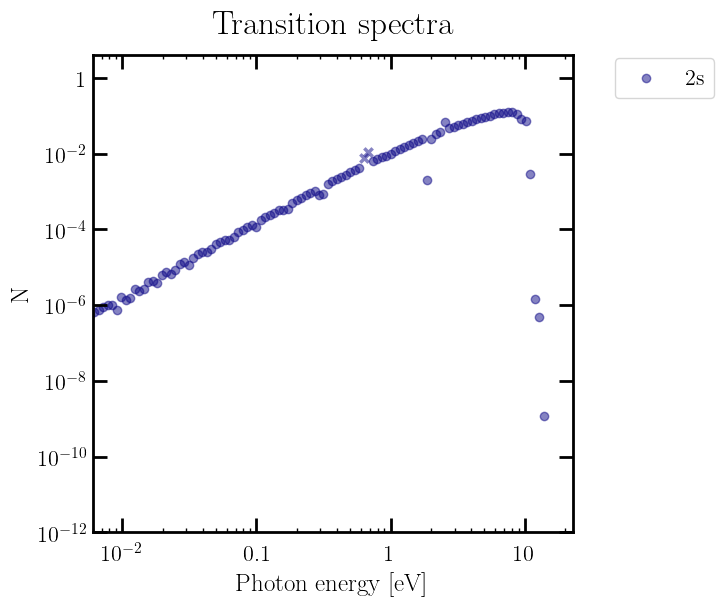

In [16]:
# Plot the spectra
nl_to_plot = ['2s']
colors = cm.plasma(np.linspace(0,1,len(nl_to_plot)))

plt.figure()
plt.loglog()

for i, nl in enumerate(nl_to_plot):
    engs = transition_specs[nl].eng
    Ns = transition_specs[nl].N
    plt.scatter(engs[Ns>0], Ns[Ns>0], color=colors[i], alpha=0.5, label=nl)
    plt.scatter(engs[Ns<0], -Ns[Ns<0], color=colors[i], alpha=0.5, marker='x')

#     plt.scatter(engs[phot1s_inds], Ns[phot1s_inds], color='r', marker='.', s=20)
#     plt.scatter(engs[phot1s_inds], -Ns[phot1s_inds], color='r', marker='.', s=20)
#     plt.scatter(engs[photCont_inds], Ns[photCont_inds], color='r', marker='.', s=20)
#     plt.scatter(engs[photCont_inds], -Ns[photCont_inds], color='r', marker='.', s=20)
    
plt.xlim(6e-3,23)
plt.ylim(1e-12,4)
plt.xlabel('Photon energy [eV]')
plt.ylabel('N')
plt.title('Transition spectra')
plt.legend(bbox_to_anchor=(1.04,1.04), loc="upper left")
plt.show()

In [18]:
test_nl = 1

#Check fraction of paths containing a photon corresponding to deexcitation to ground state
print('Fraction of paths w/ a photon going to 1s:  ', np.sum(NE_1s[test_nl,photeng>6]) / Pto1s_many[test_nl])
print('\n')

Fraction of paths w/ a photon going to 1s:   1.0000000000000002


